# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernible landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](notebook_images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="notebook_images/Haleakala_National_Park_image.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [1]:
import os
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# define training and test data directories
data_dir = 'landmark_images/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')

# getting classes names which are denoted by folder names
classes = [file[3:] for file in os.listdir(train_dir)]
# there are 50 classes in total
len(classes)

50

In [3]:
# Define transforms for training and validation data
train_transforms = transforms.Compose([transforms.RandomResizedCrop([256, 256]),
                                       transforms.RandomRotation(15),
                                       transforms.RandomHorizontalFlip(p=0.2),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

# Define transforms for test data
test_transforms = transforms.Compose([transforms.Resize([256, 256]),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

# Load all images from folders into single objects
train_and_validation_data = datasets.ImageFolder(train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

In [4]:
# Define number of images for validation and training data
num_val_instances = int(np.floor(len(train_and_validation_data) * 0.2))
num_train_instances = len(train_and_validation_data) - num_val_instances

# Radomly split non-test data into train and validation sets
train_data, val_data = torch.utils.data.random_split(train_and_validation_data, [num_train_instances, num_val_instances])

# print out the number of images in each set
print('Number training images: ', len(train_data))
print('Number training images: ', len(val_data))
print('Number test images: ', len(test_data))

Number training images:  3997
Number training images:  999
Number test images:  1250


In [5]:
# how many samples per batch to load
batch_size = 20

# prepare train, validation and test data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

# Store the loaders in a dictionary
loaders_scratch = {'train': train_loader, 'valid': val_loader, 'test': test_loader}

**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: 

**Train & Validation images:**
* Train and validation image resizing was done through randomly cropping an image at a random location and then resizing the crop to a given size. This will mean that the CNN will see a wider variety of images compared to the original dataset, as they will all correspond to a random location crop of the original image. 
* The resulting images were squares of 256x256 pixels. Originally a resize to and a centre crop to obtain 224x224 images (as mentioned [here](https://knowledge.udacity.com/questions/781486)) was considered as it is the standard for VGG, ResNet architectures which will be used for transfer learning. However, I chose to combine the transformations and keep the 256x256 pixels resolution as it will capture more information and is similarly fully divisible by 2 four times which will be needed for the chosen architecture.
* Images are randomly rotated by 15 degrees and horizontally flipped with the probability of 0.2. This will further discourage overfitting of the model and should lead to better performance as it will synthetically increase the dataset without adding any new images. 
* Images were converted to tensor data type to be used with Pytorch.
* Images are normalised using ImageNet's means and standard deviations, given the similarities between ImageNet and the landmark dataset used for this project.

**Test images:**
* Test images are simply resized to the given size to have the same shape as the train data. This ensures that they can be processed by the CNN. No random cropping is introduced for the test data, as it should be kept as close to the original images as possible.
* Test images were converted to tensor data type to be used with Pytorch.
* Test images are also normalised using ImageNet's means and standard deviations.

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

In [6]:
# Function to visualize a batch of train, validation and test data loaders
def show_images(img_loader, img_num):
    dataiter = iter(img_loader)
    batch = next(dataiter)
    labels = batch[1][0:img_num]
    images = batch[0][0:img_num]
    fig = plt.figure(figsize=(18,10))
    for i in range(img_num):
        ax = fig.add_subplot(1, img_num, i+1, xticks=[], yticks=[])
        ax.set_title(classes[labels[i]])
        image = (images[i] / 2 + 0.5).numpy()
        plt.imshow(np.transpose(image, (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


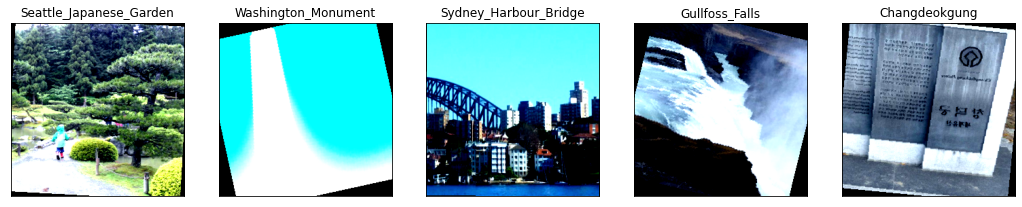

In [7]:
show_images(train_loader, 5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


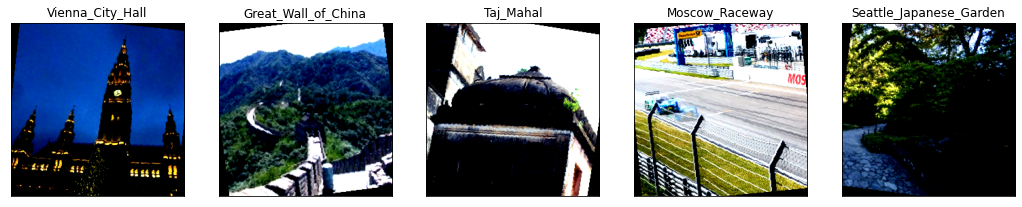

In [8]:
show_images(val_loader, 5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


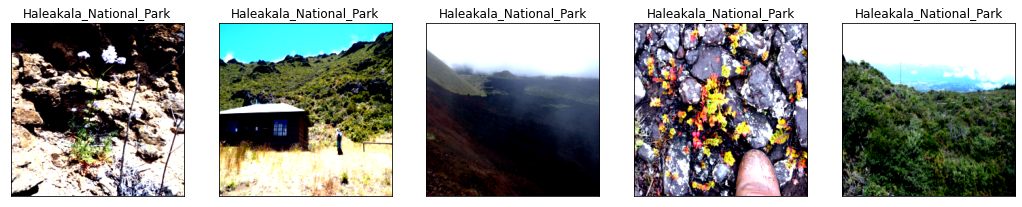

In [9]:
show_images(test_loader, 5)

### Initialize use_cuda variable

In [10]:
# Variable specifying whether the GPU can be used
use_cuda = torch.cuda.is_available()
use_cuda

True

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [11]:
import torch.nn as nn
import torch.nn.functional as F

In [12]:
# Loss function to be used for model built from scratch
criterion_scratch = nn.CrossEntropyLoss()

# Optimizer to be used for model built from scratch
def get_optimizer_scratch(model):
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    return optimizer

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [13]:
# The CNN architecture
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # convolutional layer (sees 256x256x3 image tensor)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=32)
        
        # convolutional layer (sees 128x128x32 image tensor)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=32)
        
        # convolutional layer (sees 64x64x32 image tensor)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=64)
        
        # convolutional layer (sees 32x32x64 image tensor)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(num_features=64)
        
        # max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # 1st linear layer
        self.fc1 = nn.Linear(in_features=64 * 16 * 16, out_features=512)
        
        # 2nd linear layer
        self.fc2 = nn.Linear(in_features=512, out_features=256)
        
        # 3rd linear layer
        self.fc3 = nn.Linear(in_features=256, out_features=50)

        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # sequence of convolutional, bach normalization and max pooling layers with ReLU activation function
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        
        # flatten image input
        x = x.view(-1, 64 * 16 * 16)
        
        # sequence of linear layers used for classification
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(self.fc3(x))
        return x

#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

In [14]:
# visualise model architecture
model_scratch

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=50, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

**Answer:** 

* The logic of the VGG 16 architecture was used to implement CNN architecture from scratch. More specifically, for the convolutional layers, the out channels were increased every other layer; therefore, conv2 and conv4 layers have the same number of in channels and out channels. It should be noted that compared to the VGG, the number of channels was divided by 2, so the layers start with 32, not 64 out channels. The number of channels was reduced to optimize the training process given the hardware used as sufficient accuracy was achieved even with reduced complexity. 
* Furthermore, considering that batch normalization layers reduce overfitting and can reduce vanishing/exploding gradients problems (as mentioned [here](https://towardsdatascience.com/batch-normalisation-explained-5f4bd9de5feb)), a batch normalization layer was added for each convolutional layer. 
* Considering that the input data consisted of 256x256 pixels, the linear classification layers reflect that in the chosen number of nodes as the first layer contains 512 nodes, the second 256 while the last one has to have 50 output nodes given the number of classes.

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [15]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the model to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record the average training loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))       
            

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))

        ## If the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} ---> {:.6f}). '.format(valid_loss_min, valid_loss))
            print('Model with validation {:.6f} saved. '.format(valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
 
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [16]:
torch.cuda.empty_cache()

In [17]:
def custom_weight_init(m):
    classname = m.__class__.__name__
    
    # for every Convolutional layer in a model
    if classname.find('Conv') != -1:
        # the number of the inputs
        n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        m.weight.data.normal_(0, np.sqrt(2.0 / n))
    
    # for every Linear layer in a model
    if classname.find('Linear') != -1:
        # the number of the inputs
        n = m.in_features
        m.weight.data.normal_(0, (1.0/np.sqrt(n)))

* Weight initialisation for convolutional layers was based on [this post](https://towardsdatascience.com/weight-initialization-techniques-in-neural-networks-26c649eb3b78)
* Weight initialisation for linear layers was based on the rule of thumb mentioned in the Nanodegree

In [19]:
# Train the model created from scratch using custom weight initialisation
model_scratch.apply(custom_weight_init)
model_scratch = train(35, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'scratch_custom_weights.pt')

Epoch: 1 	Training Loss: 3.966725 	Validation Loss: 3.845750
Validation loss decreased (inf ---> 3.845750). 
Model with validation 3.845750 saved. 
Epoch: 2 	Training Loss: 3.860449 	Validation Loss: 3.766305
Validation loss decreased (3.845750 ---> 3.766305). 
Model with validation 3.766305 saved. 
Epoch: 3 	Training Loss: 3.809133 	Validation Loss: 3.694307
Validation loss decreased (3.766305 ---> 3.694307). 
Model with validation 3.694307 saved. 
Epoch: 4 	Training Loss: 3.759113 	Validation Loss: 3.641695
Validation loss decreased (3.694307 ---> 3.641695). 
Model with validation 3.641695 saved. 
Epoch: 5 	Training Loss: 3.740614 	Validation Loss: 3.600325
Validation loss decreased (3.641695 ---> 3.600325). 
Model with validation 3.600325 saved. 
Epoch: 6 	Training Loss: 3.690842 	Validation Loss: 3.534306
Validation loss decreased (3.600325 ---> 3.534306). 
Model with validation 3.534306 saved. 
Epoch: 7 	Training Loss: 3.667295 	Validation Loss: 3.522789
Validation loss decreased 

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [20]:
torch.cuda.empty_cache()

In [21]:
num_epochs = 35

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# Train the model created from scratch using default weight initialisation
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'scratch_default.pt')

Epoch: 1 	Training Loss: 3.917429 	Validation Loss: 3.877679
Validation loss decreased (inf ---> 3.877679). 
Model with validation 3.877679 saved. 
Epoch: 2 	Training Loss: 3.849826 	Validation Loss: 3.758481
Validation loss decreased (3.877679 ---> 3.758481). 
Model with validation 3.758481 saved. 
Epoch: 3 	Training Loss: 3.737633 	Validation Loss: 3.612171
Validation loss decreased (3.758481 ---> 3.612171). 
Model with validation 3.612171 saved. 
Epoch: 4 	Training Loss: 3.644453 	Validation Loss: 3.545250
Validation loss decreased (3.612171 ---> 3.545250). 
Model with validation 3.545250 saved. 
Epoch: 5 	Training Loss: 3.598859 	Validation Loss: 3.484604
Validation loss decreased (3.545250 ---> 3.484604). 
Model with validation 3.484604 saved. 
Epoch: 6 	Training Loss: 3.565053 	Validation Loss: 3.429630
Validation loss decreased (3.484604 ---> 3.429630). 
Model with validation 3.429630 saved. 
Epoch: 7 	Training Loss: 3.526741 	Validation Loss: 3.391282
Validation loss decreased 

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [22]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the model to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [23]:
# load the scratch model with custom initilization that got the best validation accuracy
model_scratch.load_state_dict(torch.load('scratch_custom_weights.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.773235


Test Accuracy: 32% (405/1250)


In [24]:
# load the scratch model with default initilization that got the best validation accuracy
model_scratch.load_state_dict(torch.load('scratch_default.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.509674


Test Accuracy: 35% (442/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [25]:
# Same transofmration and data loaders are used for the transfer learning models as for the model that was built from scratch
loaders_transfer = {'train': train_loader, 'valid': val_loader, 'test': test_loader}

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [26]:
# Loss function to be used for vgg16 and resnet50 models
criterion_transfer = nn.CrossEntropyLoss()

# Optimizer to be used for vgg16 and resnet50 models
def get_optimizer_transfer(model):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    return optimizer  

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

## VGG16

In [27]:
torch.cuda.empty_cache()

In [28]:
# VGG16 model architecture

# download the pretrained vgg16 model
vgg16 = models.vgg16(pretrained=True)

# freeze the weights of all layers that are not part of classifier part of vgg16
for param in vgg16.features.parameters():
    param.requires_grad = False

# change the output layer of vgg16 to be suited for landmark classification
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, len(classes))

#-#-#-#-#-#-#-#-#-#-#-#-#-#

# move model to GPU
if use_cuda:
    vgg16 = vgg16.cuda()

In [29]:
# visualising new model architecture
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [30]:
# Train the vgg16 model and save the best model parameters at filepath 'vgg16.pt'
num_epochs = 35

vgg16 = train(num_epochs, loaders_transfer, vgg16, get_optimizer_transfer(vgg16), 
                      criterion_transfer, use_cuda, 'vgg16.pt')

Epoch: 1 	Training Loss: 2.593788 	Validation Loss: 1.871177
Validation loss decreased (inf ---> 1.871177). 
Model with validation 1.871177 saved. 
Epoch: 2 	Training Loss: 1.776783 	Validation Loss: 1.675384
Validation loss decreased (1.871177 ---> 1.675384). 
Model with validation 1.675384 saved. 
Epoch: 3 	Training Loss: 1.546448 	Validation Loss: 1.546564
Validation loss decreased (1.675384 ---> 1.546564). 
Model with validation 1.546564 saved. 
Epoch: 4 	Training Loss: 1.443273 	Validation Loss: 1.511047
Validation loss decreased (1.546564 ---> 1.511047). 
Model with validation 1.511047 saved. 
Epoch: 5 	Training Loss: 1.321443 	Validation Loss: 1.435056
Validation loss decreased (1.511047 ---> 1.435056). 
Model with validation 1.435056 saved. 
Epoch: 6 	Training Loss: 1.222948 	Validation Loss: 1.458878
Epoch: 7 	Training Loss: 1.182405 	Validation Loss: 1.423846
Validation loss decreased (1.435056 ---> 1.423846). 
Model with validation 1.423846 saved. 
Epoch: 8 	Training Loss: 1

In [31]:
# load vgg16 parameters that got the best validation accuracy
vgg16.load_state_dict(torch.load('vgg16.pt'))

<All keys matched successfully>

In [32]:
# Test vgg16 model performance on the test images
test(loaders_transfer, vgg16, criterion_transfer, use_cuda)

Test Loss: 0.970932


Test Accuracy: 79% (989/1250)


---

## ResNet50

In [33]:
# ResNet50 model architecture

# download the pretrained resnet50 model
resnet50 = models.resnet50(pretrained=True)

# freeze all model weights
for param in resnet50.parameters():
    param.requires_grad = False

# change the output layer of resnet50 to be suited for landmark classification    
resnet50.fc = nn.Linear(resnet50.fc.in_features, len(classes))

# unfreeze the weights of the output layer
for param in resnet50.fc.parameters():
    param.requires_grad = True

#-#-#-#-#-#-#-#-#-#-#-#-#-#

# move model to GPU
if use_cuda:
    resnet50 = resnet50.cuda()

In [34]:
# visualising new model architecture
resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [35]:
# Train the vgg16 model and save the best model parameters at filepath 'resnet50.pt'
num_epochs = 35

resnet50 = train(num_epochs, loaders_transfer, resnet50, get_optimizer_transfer(resnet50), 
                      criterion_transfer, use_cuda, 'resnet50.pt')

Epoch: 1 	Training Loss: 3.726468 	Validation Loss: 3.461082
Validation loss decreased (inf ---> 3.461082). 
Model with validation 3.461082 saved. 
Epoch: 2 	Training Loss: 3.277653 	Validation Loss: 3.030967
Validation loss decreased (3.461082 ---> 3.030967). 
Model with validation 3.030967 saved. 
Epoch: 3 	Training Loss: 2.926834 	Validation Loss: 2.698235
Validation loss decreased (3.030967 ---> 2.698235). 
Model with validation 2.698235 saved. 
Epoch: 4 	Training Loss: 2.641670 	Validation Loss: 2.483121
Validation loss decreased (2.698235 ---> 2.483121). 
Model with validation 2.483121 saved. 
Epoch: 5 	Training Loss: 2.422922 	Validation Loss: 2.292622
Validation loss decreased (2.483121 ---> 2.292622). 
Model with validation 2.292622 saved. 
Epoch: 6 	Training Loss: 2.248299 	Validation Loss: 2.153037
Validation loss decreased (2.292622 ---> 2.153037). 
Model with validation 2.153037 saved. 
Epoch: 7 	Training Loss: 2.115791 	Validation Loss: 2.012005
Validation loss decreased 

In [36]:
# load ResNet50 parameters that got the best validation accuracy
resnet50.load_state_dict(torch.load('resnet50.pt'))

<All keys matched successfully>

In [37]:
# Test ResNet50 model performance on the test images
test(loaders_transfer, resnet50, criterion_transfer, use_cuda)

Test Loss: 0.958837


Test Accuracy: 74% (936/1250)


__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  

Two known pre-trained models which are part of the PyTorch library were tested in the project. The VGG 16 model, which was previously used in this nanodegree and the resnet50 model, which is mentioned in the PyTorch documentation [here](https://pytorch.org/vision/stable/models.html). This was done to determine which pre-trained model would be best suited for landmark classification. 

**VGG16:**
* VGG16 was pre-trained on the ImageNet dataset, which is similar to the landmark dataset that is used in this project; therefore, only the output layer was changed to allow the classification of 50 classes present in the dataset. 
* However, VGG16 has classifier layers that are easily accessible in the model structure and hence the weights in this portion of the model were also trained on the landmark dataset in this project.

**ResNet50:**
* ResNet50 was also pre-trained on the ImageNet dataset, which is similar to the landmark dataset that is used in this project; therefore, only the output layer was changed to allow the classification of 50 classes present in the dataset. 
* Alternatively to VGG16, ResNet50 only has a single output classifier level, and the weights only in this level were updated. 

Ultimately, the adapted VGG16 had the best accuracy on the test set and hence was chosen to be the main model used for transfer learning in this project.

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [38]:
# Since vgg16 had better performance on the test set it was chosen to be the transfer model in this project
model_transfer = vgg16

# Set model parameters to best model parameters of vgg16 model
model_transfer.load_state_dict(torch.load('vgg16.pt'))

torch.save(model_transfer.state_dict(), 'model_transfer.pt')

model_transfer.load_state_dict(torch.load('model_transfer.pt'))

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [39]:
# Test the transfer model to ensure it has the same accuracy on the test set as the vgg16 model (which it was based on)
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.970932


Test Accuracy: 79% (989/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [40]:
# create an indexed dictionary of classes list
classes_dict = {index : image_class for index, image_class in enumerate(classes)}

In [41]:
import cv2
from PIL import Image

def predict_landmarks(img_path, k, use_cuda):
    # set model to evaluation mode
    model_transfer.eval()
    
    image = Image.open(img_path)
    
    # set model transformations to be the same as the test images transformation
    image_transforms = transforms.Compose([transforms.Resize([256, 256]),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])
    
    # transform the image and add a 4th dimention
    image = image_transforms(image).unsqueeze(0)
    
    if use_cuda:
        image = image.cuda()
    
    # forward pass through CNN
    predictions = model_transfer(image)
    
    # store the names of the top k landmarks predicted by the transfer learned CNN
    top_p, top_classes = predictions.topk(k, dim=1)
    
    # store the names of the top k predicted classes
    top_k_class_names = [classes_dict[top_class] for top_class in top_classes[0].tolist()]
    
    #set model to training mode
    model_transfer.train()
    
    return  top_k_class_names

In [42]:
# test on a sample image
predict_landmarks('landmark_images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5, use_cuda)

['Golden_Gate_Bridge',
 'Forth_Bridge',
 'Brooklyn_Bridge',
 'Sydney_Harbour_Bridge',
 'Temple_of_Heaven']

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

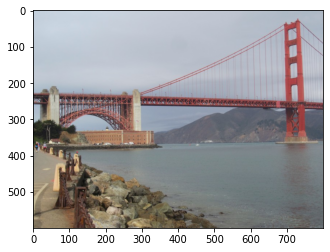

IS this picture of the 
Golden_Gate_Bridge, Forth_Bridge or Brooklyn_Bridge


In [43]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3, use_cuda)
    
    # display image and display landmark predictions
    image = Image.open(img_path)
    plt.imshow(image)
    plt.show()
    print('IS this picture of the \n{}, {} or {}'.format(predicted_landmarks[0],
                                                          predicted_landmarks[1], 
                                                          predicted_landmarks[2]))

    

# test on a sample image
suggest_locations('landmark_images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

The output is much better than I expected. As can be seen below, the model manages to correctly classify the landmarks when they are clearly visible in the picture. More interestingly, the model manages to correctly classify the second Edinburgh castle image, which was taken inside the Edinburgh castle, but the castle itself is not visible in the picture. On the other hand, this is not always the case, as demonstrated by the second picture of the Brooklyn bridge, which doesn't show the bridge itself in the picture but was rather likely taken from the bridge. 

Three possible points for improvement:
1. Include more data for each category where the landmark is not clearly visible, but instead, a certain feature is depicted.
2. While both VGG16 and ResNet50 were trained on the ImageNet dataset, they had different performances on the landmark dataset in question. Hence, other pre-trained models could be tested on the landmark dataset.
3. Given the hardware limitations of this project and in order to conform to standard image processing, the size of the images was significantly reduced, meaning that some of the data were inevitably lost. Hence the provided model architectures could be altered and trained on different resized images given a larger timeframe.

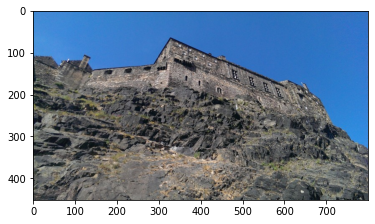

IS this picture of the 
Edinburgh_Castle, Great_Wall_of_China or Machu_Picchu


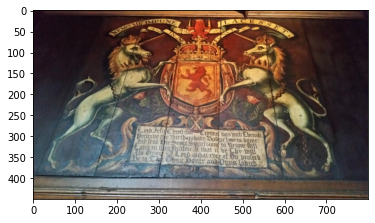

IS this picture of the 
Edinburgh_Castle, Prague_Astronomical_Clock or Hanging_Temple


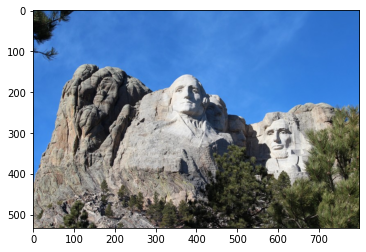

IS this picture of the 
Mount_Rushmore_National_Memorial, Externsteine or Banff_National_Park


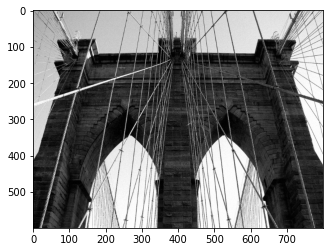

IS this picture of the 
Brooklyn_Bridge, Golden_Gate_Bridge or Sydney_Harbour_Bridge


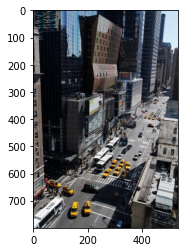

IS this picture of the 
Moscow_Raceway, Petronas_Towers or Terminal_Tower


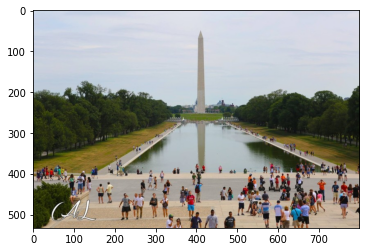

IS this picture of the 
Washington_Monument, Eiffel_Tower or Stockholm_City_Hall


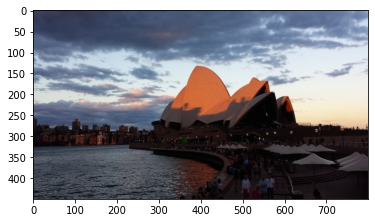

IS this picture of the 
Sydney_Opera_House, Sydney_Harbour_Bridge or Monumento_a_la_Revolucion


In [44]:
suggest_locations('landmark_images/test/10.Edinburgh_Castle/0ac1ab085a70b7a3.jpg')

suggest_locations('landmark_images/test/10.Edinburgh_Castle/7dd81e3ac1cb8982.jpg')

suggest_locations('landmark_images/test/11.Mount_Rushmore_National_Memorial/0f6abbd3097ca140.jpg')

suggest_locations('landmark_images/test/30.Brooklyn_Bridge/11a81fe38b0333ca.jpg')

suggest_locations('landmark_images/test/30.Brooklyn_Bridge/25005e1eaacf5bb5.jpg')

suggest_locations('landmark_images/test/31.Washington_Monument/5aa9ae7d02df2b24.jpg')

suggest_locations('landmark_images/test/33.Sydney_Opera_House/1a14b4a5af6bac9c.jpg')